# Support Vector Machines

In this section of the assignment, you will get to implement Support Vector Machines which are among the best (and many believe are indeed the best) “off-the-shelf” supervised learning algorithm.

This section is further divided into 3 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the next subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Subsection 1

In [2]:
# Feel free to use this helper function to visualize 2D points X with labels +1 or -1
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

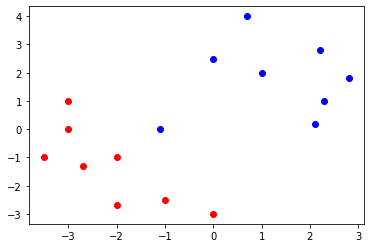

In [3]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_points(X, y)
plt.show()

In the next cell you are required to derive the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles. Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here.**

**Note: You cannot use sklearn SVM functions here.**

#### Maximum Margin Classifier

Say we have labelled (two-class) data-points $(\mathbf{x}_i, y_i)$. We wish to separate them using a linear decision boundary. This decision boundary can be parameterized by $\mathbf{w}$ (having the same number of elements as $\mathbf{x}_i$ values do) and a bias $b$ (so that we allow the decision boundary to _not_ be anchored to the origin). Therefore, the decision boundary is given by

$$ f(\mathbf{x}_i; \mathbf{w}, b) = \mathbf{w}^\top \mathbf{x}_i - b = 0 $$

We'd want a point to be as distant from this boundary as possible. Therefore, we define two _parallel_ lines to this (called as the margins) and define them with the equations

$$ \mathbf{w}^\top \mathbf{x} - b = 1 $$

If the LHS is greater than $1$, then the class is $\omega_1$. For the second margin, we have

$$ \mathbf{w}^\top \mathbf{x} - b = -1 $$

If the LHS is less than $-1$, then the class is $\omega_{-1}$. We want to **maximize** the distance (gap) between the margins. For this, we need to first find the length of the gap between the margins. Pick a point $\mathbf{x}_0$ on the second margin $ \mathbf{w}^\top \mathbf{x} - b = -1 $. This means $ \mathbf{w}^\top \mathbf{x}_0 - b = -1 $. Note that the perpendicular unit vector to this line (margin) will be $\mathbf{w}/\left \| \mathbf{w} \right \|$. From $\mathbf{x}_0$, if we travel along this perpendicular vector for $r$ units (let $r$ be the perpendicular distance between the margins), we must reach the first margin given by $ \mathbf{w}^\top \mathbf{x} - b = 1 $. This point (which lies on this first margin) will be $\mathbf{x}_0 + \frac{\mathbf{w}}{\left \| \mathbf{w} \right \|} r$. Substituting this in the second margin and solving for $r$ gives

$$ \mathbf{w}^\top \left ( \mathbf{x}_0 + \frac{\mathbf{w}}{\left \| \mathbf{w} \right \|} r \right ) - b = 1 
\Rightarrow \left ( \mathbf{w}^\top \mathbf{x}_0 - b \right ) + \frac{\mathbf{w}^\top \mathbf{w}}{\left \| \mathbf{w} \right \|} r = 1
\Rightarrow -1 + \frac{\left \| \mathbf{w} \right \|^2}{\left \| \mathbf{w} \right \|} r = 1
\Rightarrow r = \frac{2}{\left \| \mathbf{w} \right \|} $$

We need to **maximize** $r$. In order to do that, we can simply minimize $\left \| \mathbf{w} \right \|$. But note that we cannot have the trivial solution of $\mathbf{w} = \mathbf{0}$ (it'll not be a boundary dependent on data at all!). Additionally, we have constraints _from the data points_ as $\mathbf{w}^\top \mathbf{x}_i - b \ge 1$ (if $y_i = 1$: the sample belongs to $\omega_1$) and $\mathbf{w}^\top \mathbf{x}_i - b \le -1$ (if $y_i = -1$: the sample belongs to $\omega_{-1}$).

Therefore, the problem reduces to: _Minimizing_ $\left \| \mathbf{w} \right \|$, _subjected to_ $y_i \left (\mathbf{w}^\top \mathbf{x}_i - b \right ) \ge 1$

Use [cvxpy](https://www.cvxpy.org/) to find the optimal $\mathbf{w}$ and $b$

In [24]:
# Extract shapes
N, d = X.shape
w = cp.Variable(d)
b = cp.Variable(1)
# All constraints (for all points)
constraints = [y[i] * (w.T @ X[i, :] - b) >= 1 for i in range(N)]
obj = cp.Minimize(cp.norm(w))   # Minimize the norm of w
prob = cp.Problem(obj, constraints) # Define problem
result = prob.solve()   # Solve for w and b
print(f"w: {w.value}, b: {b.value}")

w: [-1.73913043 -1.30434783], b: [2.91304348]


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines

You may want to create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

In [63]:
# Decision boundary
y_x_db = lambda x_val: (b.value - w.value[0] * x_val)/w.value[1]
# Margin (+1 side)
y_x_mp1 = lambda x_val: (1 + b.value - w.value[0] * x_val)/w.value[1]
# Margin (-1 side)
y_x_mn1 = lambda x_val: (b.value - 1 - w.value[0] * x_val)/w.value[1]
# Function
def svm_db(x_min, x_max, y_min, y_max):
    plt.plot([x_min, x_max], [y_x_db(x_min), y_x_db(x_max)], 'g-')
    plt.plot([x_min, x_max], [y_x_mp1(x_min), y_x_mp1(x_max)], 'r--')
    plt.plot([x_min, x_max], [y_x_mn1(x_min), y_x_mn1(x_max)], 'b--')
    plt.xlim([x_min - 0.2, x_max + 0.2])
    plt.ylim([y_min - 0.2, y_max + 0.2])

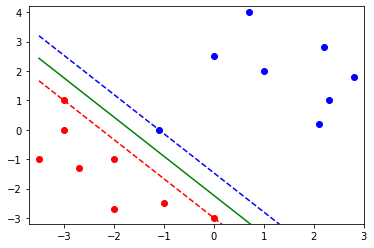

In [64]:
# Write your code here
plot_points(X, y)
# Show the decision boundary
x_min = float(np.min(X[:, 0]))
x_max = float(np.max(X[:, 0]))
y_min = float(np.min(X[:, 1]))
y_max = float(np.max(X[:, 1]))
# Red: +1, Blue: -1, Green: 0 (decision boundary)
svm_db(x_min, x_max, y_min, y_max)
plt.show()

Notice that there are _exactly_ three lagrangian multipliers that have the highest weight in the constraints

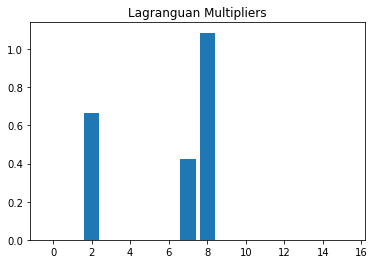

Points are (array([2, 7, 8], dtype=int64),)


In [67]:
# Lagrangian Multipliers
_l_muls = np.array([constraints[i].dual_value for i in range(N)])
_l_muls = _l_muls.flatten()
plt.bar(np.arange(N), _l_muls)
plt.title("Lagranguan Multipliers")
plt.show()
p = np.where(_l_muls > 1e-2)
print(f"Points are {p}")

In the next cell please plot only the support vectors along with the boundary, w vector, and margins. 

**Note: You are not supposed to hard-code the points here.**

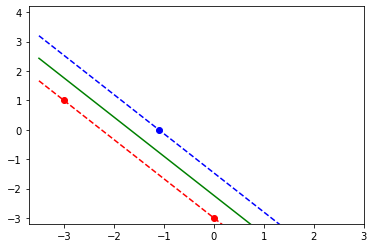

In [68]:
# Write your code here
plot_points(X[p, :][0], y[p])
svm_db(x_min, x_max, y_min, y_max)
plt.show()

In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Explain your observations theoretically.

In [ ]:
# Re-create the Synthetic Data by adding the points and visualize the points

In [ ]:
# Solve for the decision boundary using this modified dataset

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

**Note: Use the modified X and y i.e after adding points in previous cell.**

In [ ]:
# Write your code here for C= 0.01

In [ ]:
# Write your code here for C= 0.1

In [ ]:
# Write your code here for C= 3

In [ ]:
# Write your code here for C= 10

In [ ]:
# Write your code here for C= 100

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

In [ ]:
# Write your Code here

### Subsection 2

In [ ]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz

In [ ]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST

In [ ]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

In [ ]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.